In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from neural_odes import *
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")

## Data Generation

In [2]:
dt = 0.02
t0 = 0
y0 = torch.Tensor([1.0]).float()
Tn = 1
t = torch.arange(t0, 2*Tn+dt, dt).float()

In [3]:
f_con = lambda t,y : 2
f_cos = lambda t,y : torch.cos(2*math.pi*t)
f_hyp = lambda t,y : -2*t*y ** 2
y_cos_exact = torch.sin(2*math.pi*t) / (2*math.pi) + y0
y_con_exact = 2*t + y0
y_hyp_exact = 1 / (1+t ** 2)

In [4]:
def ode_solver(f, t, y0, solver):
    y = []
    # Inital condiiton
    y.append(y0)
    if solver == 'rk4':
        for n in range(0, N-1):
            k1 = dt * f(t[n],y[n]) #f is lambd function
            k2 = dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = dt * f(t[n] + dt, y[n] + k3)
            y.append(y[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4))
    elif solver == 'forward_euler':
        for n in range(0,N-1):
            y.append(y[n] + dt * f(t[n],y[n]))
    else:
        return 'ODE solver is not supported!'
    return torch.cat(y, dim=0)
#y_rk4 = ode_solver(f_hyp, t,y0, 'rk4')

## DNN(t)

In [5]:
def RMSE(a, b):
    return torch.sqrt(torch.mean((a - b)**2)).cpu().data.numpy()

class FC_layer(nn.Module):
    def __init__(self, input_dim, output_dim, batch_norm = False):
        super(FC_layer, self).__init__()
        if batch_norm:
            self.model = nn.Sequential(
                nn.Linear(input_dim, output_dim),
                nn.BatchNorm1d(output_dim),
                nn.ReLU(inplace=True)
            )
        else:
            self.model = nn.Sequential(
                nn.Linear(input_dim, output_dim),
                nn.ReLU(inplace=True)
            )
            
    def forward(self, xx):
        return self.model(xx)
        
class DNN_t(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(DNN_t, self).__init__()
        self.model = [FC_layer(input_dim, hidden_dim)] + \
                     [FC_layer(hidden_dim, hidden_dim) for i in range(num_layers-2)] + \
                     [nn.Linear(hidden_dim, output_dim)]
        self.model = nn.Sequential(*self.model)
    def forward(self, t):
        y_preds = []
        for i in range(len(t)):
            y_preds.append(self.model(t[i].reshape(1,1)))
        return torch.cat(y_preds, dim = -1)

In [47]:
rmse_samples = []
num_samples = []
idx  = 2
y_f = lambda t: torch.sin(2*math.pi*t) / (2*math.pi) + y0#lambda t: 1 / (1+t ** 2) #
# f_con = lambda t: 2*t + y0
# f_hyp = lambda t: 1 / (1+t ** 2)
t_extra = torch.arange(Tn*idx+dt/2, Tn*idx + Tn*2, dt/2).float()[:50]
y_extra = y_f(t_extra)

t_inter = torch.arange(t0+dt/2, Tn*idx, dt).float()
y_inter = y_f(t_inter)

t_train = torch.arange(t0, Tn*idx, dt).float()
y_train = y_f(t_train)
num_samples.append(len(t_train))
print(len(t_train))

t_total = torch.arange(t0, 2*Tn, dt/2).float()[:150]
y_total = y_f(t_total)
rmse_hiddim = []

model_fc = DNN_t(input_dim = 1, hidden_dim = 64, output_dim = 1, num_layers = 2).cuda()
optimizer = torch.optim.Adam(model_fc.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 50, gamma=0.9)
num_epochs = 5000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))

min_loss = 10

for e in tqdm_epochs:
    #scheduler.step()
    y = model_fc(t_train.to(device))[0]
    loss = loss_fun(y, y_train.to(device))
    if loss.item() < min_loss:
        best_model = model_fc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

inter_pred = best_model(t_inter.to(device))[0].cpu()
extra_pred = best_model(t_extra.to(device))[0].cpu()
train_pred = best_model(t_train.to(device))[0].cpu()
inter_error = RMSE(inter_pred, y_inter)
extra_error = RMSE(extra_pred, y_extra)
train_error = RMSE(train_pred, y_train)
rmse_samples.append([inter_error, extra_error, train_error])

100


In [27]:
rmse_samples = np.array(rmse_samples)
np.save("rmse_num_cos2.npy", rmse_samples)

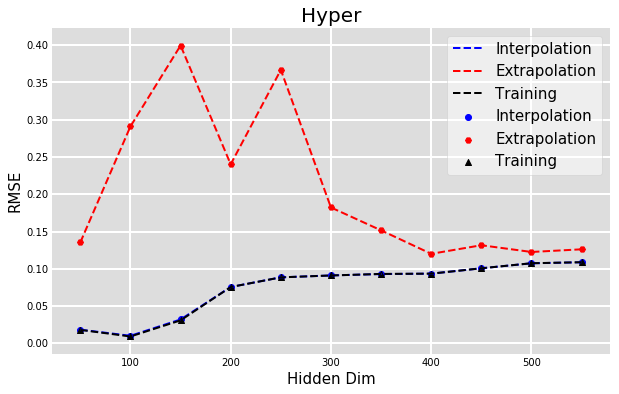

In [28]:
h = list(range(4, 64+4, 4))
fig=plt.figure(figsize=(10, 6))#fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
idx = 0
ax.plot(num_samples[:-1], rmse_samples[:,0], 'b', alpha=1, lw=2, linestyle = "--", label='Interpolation')
ax.plot(num_samples[:-1], rmse_samples[:,1], 'r', alpha=1, lw=2, linestyle = "--", label='Extrapolation')
ax.plot(num_samples[:-1], rmse_samples[:,2], 'black', alpha=1, lw=2, linestyle = "--", label='Training')
ax.scatter(num_samples[:-1], rmse_samples[:,0], c= 'b', marker = "o", label='Interpolation')
ax.scatter(num_samples[:-1], rmse_samples[:,1], c='r', marker = "H", label='Extrapolation')
ax.scatter(num_samples[:-1], rmse_samples[:,2], c='black', marker = "^", label='Training')

ax.set_xlabel('Hidden Dim', size = 15)
ax.set_ylabel('RMSE', size = 15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 15, loc = 0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Hyper" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("Hyper_rmse.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

In [58]:
idx = 2
y_f = lambda t: torch.sin(2*math.pi*t) / (2*math.pi) + y0#lambda t: 1 / (1+t ** 2) #
# f_con = lambda t: 2*t + y0
# f_hyp = lambda t: 1 / (1+t ** 2)
t_extra = torch.arange(Tn*idx+dt/2, Tn*idx + Tn*2, dt/2).float()[:50]
y_extra = y_f(t_extra)

t_inter = torch.arange(t0+dt/2, Tn*idx, dt).float()
y_inter = y_f(t_inter)

t_train = torch.arange(t0, Tn*idx, dt).float()
y_train = y_f(t_train)
num_samples.append(len(t_train))
print(len(t_train))

t_total = torch.arange(t0, Tn*idx , dt/2).float()
y_total = y_f(t_total)

100


In [56]:
Tn*idx + Tn*2

2

In [57]:
len(t_total)

400

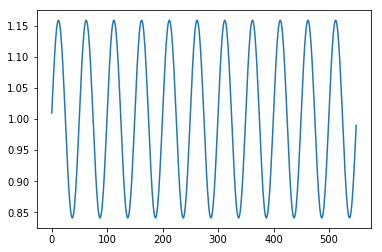

In [36]:
plt.plot(y_inter.cpu().data.numpy())

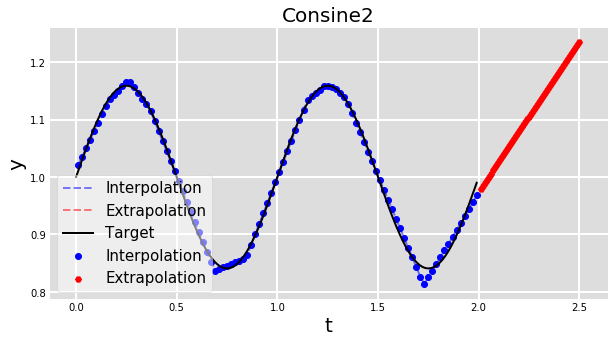

In [60]:
x = np.linspace(0, 30, 31)[:-1]
fig=plt.figure(figsize=(10, 5))#fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
idx = 0
ax.plot(t_inter.cpu().data.numpy(), inter_pred.cpu().data.numpy(), 'b', alpha=0.5, lw=2, linestyle = "--", label='Interpolation')
ax.plot(t_extra.cpu().data.numpy(), extra_pred.cpu().data.numpy(), 'r', alpha=0.5, lw=2, linestyle = "--", label='Extrapolation')
ax.scatter(t_inter.cpu().data.numpy(), inter_pred.cpu().data.numpy(), c = 'b', marker = "o", label='Interpolation')
ax.scatter(t_extra.cpu().data.numpy(), extra_pred.cpu().data.numpy(), c = 'r', marker = "H", label='Extrapolation')

ax.plot(t_total.cpu().data.numpy(), y_total.cpu().data.numpy(), 'black', alpha=1, lw=2,  label='Target')

ax.set_xlabel('t', size = 20)
ax.set_ylabel('y', size = 20)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 15, loc = 0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Consine2" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("Consine_pred2.png", dpi = 400 , bbox_inches = "tight")    
plt.show()